<a href="https://colab.research.google.com/github/AlekseevaTatiana23/Alekseeva.github.io/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%228_%D1%81%D0%B5%D0%BC%D0%B8%D0%BD%D0%B0%D1%80_ipynb%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from scipy.stats import ttest_1samp, ttest_ind, norm, t, kstest, shapiro, mannwhitneyu #импорт библиотек по статистике
import statsmodels.api as sm #импорт библиотек по статистике
from statsmodels.stats.power import TTestIndPower
import numpy as np # библиотека для мат.функций.

import warnings # код убирает предупреждения
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

import matplotlib.pyplot as plt # для графиков
import seaborn as sns # для графиков
import pandas as pd # для работы сданными

In [ ]:
data = pd.read_excel('AB_Test_Results (2).xlsx')

In [ ]:
data # вывожу датасет

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0


In [ ]:
data.info() # функция дает инфо по таблице.сверяем

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [ ]:
data.describe() # дает статистику по числовым столбцам

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [ ]:
data.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [ ]:
data.VARIANT_NAME.value_counts() # каунтит по группа разница не большая, это ок

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

In [ ]:
data.USER_ID.nunique()

6324

In [ ]:
data=data.groupby(['USER_ID', 'VARIANT_NAME'], as_index=False).agg({'REVENUE':'sum'})

In [ ]:
data.shape

(7865, 3)

In [ ]:
data.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME':'count'})['VARIANT_NAME'].value_counts()

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

In [ ]:
unique_id=(data.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME':'count'})).query('VARIANT_NAME ==1').USER_ID.values

In [ ]:
data_clean=data[data.USER_ID.isin(unique_id)].copy(deep=True)

In [ ]:
data_clean.shape

(4783, 3)

In [ ]:
data_clean.describe()

,USER_ID,REVENUE
count,4783.000000,4783.000000
mean,4994.395777,0.135873
std,2898.618472,3.011392
min,2.000000,0.000000
25%,2476.000000,0.000000
50%,4975.000000,0.000000
75%,7515.000000,0.000000
max,9998.000000,196.010000


In [ ]:
control=data_clean.query('VARIANT_NAME == "control"')
test=data_clean.query('VARIANT_NAME == "variant"')

После обработки данных проверим распределение на нормальность

In [ ]:
alpha=0.05
st=shapiro(data.REVENUE)
print('Discription is {}normal\n'.format({True: 'not', False: ''}[st[1]<alpha]))

Discription is notnormal



Постоим график дохода на пользователя в группах

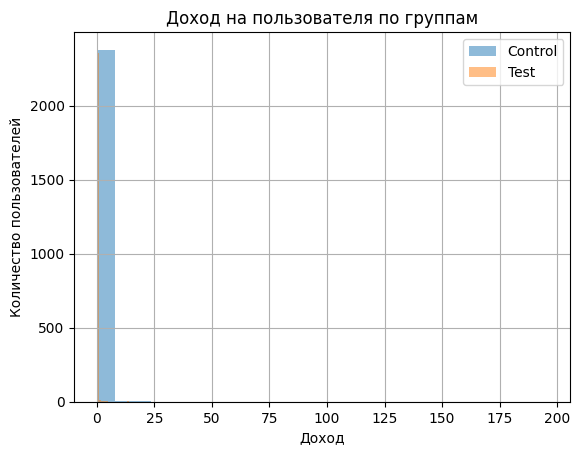

In [ ]:
control.REVENUE.hist(bins=25, alpha = 0.5, label='Control')
test.REVENUE.hist(bins=25, alpha = 0.5, label='Test')
plt.title('Доход на пользователя по группам')
plt.xlabel('Доход')
plt.ylabel('Количество пользователей')
plt.legend()

In [ ]:
mw_stats = mannwhitneyu(x=control.REVENUE.values, y=test.REVENUE.values)
mw_stats

MannwhitneyuResult(statistic=2874161.0, pvalue=0.2104875008271777)

Построим боксплот по пользователям

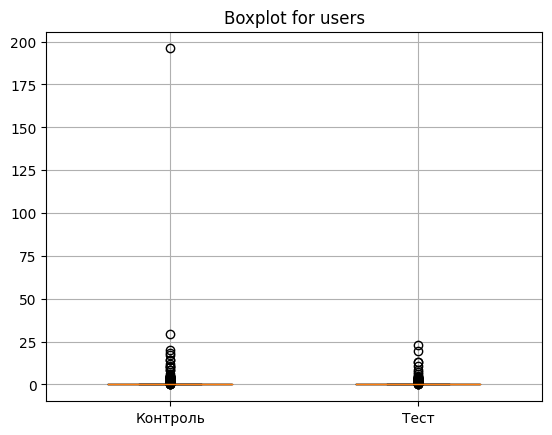

In [ ]:
plt.boxplot([control.REVENUE, test.REVENUE], labels=['Контроль', 'Тест'], widths=0.5)
plt.title('Boxplot for users')
plt.grid(axis='both')

In [ ]:
ttest_ind(control.REVENUE.values, test.REVENUE.values, equal_var=False)

TtestResult(statistic=1.3996978409515475, pvalue=0.16172355638776942, df=2590.554714694372)

Мощность теста

In [ ]:
control_mean=control.REVENUE.values.mean()
test_mean=test.REVENUE.values.mean()

control_std=control.REVENUE.values.std()
test_std=test.REVENUE.values.std()

print(len(control.REVENUE.values), len(test.REVENUE.values))

2390 2393


In [ ]:
n=len(control.REVENUE.values)
S=np.sqrt((test_std**2 + control_std**2)/2)
ef=float((control_mean - test_mean)/S)

In [ ]:
alpha = 0.05
analysis = TTestIndPower()
result = analysis.solve_power(ef, power=None, nobs1=n, ratio = 1.0, alpha=alpha)
result

0.28803096229144043

p value  больше чем 0.05 значит различий между группами нет. При полученных значениях мощности нельзя сделать достоверное заключение. Лучше провести тест повторно, предварительно проверив его на корректность выполнения
